## Data Exploration

In [5]:
import pandas as pd 

df = pd .read_csv("synthetic_logs.csv")
df.head()

,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [6]:
df[df.target_label=="HTTP Status"].sample(8)

,timestamp,source,log_message,target_label,complexity
1289,2025-07-10 10:39:22,AnalyticsEngine,nova.osapi_compute.wsgi.server [req-03cc7683-8...,HTTP Status,bert
1416,2025-02-22 16:06:48,ModernHR,nova.osapi_compute.wsgi.server [req-ce6ebea3-0...,HTTP Status,bert
2060,2025-04-03 15:45:55,BillingSystem,nova.metadata.wsgi.server [req-d1ae2038-d065-4...,HTTP Status,bert
1583,2025-04-20 15:06:21,ModernCRM,nova.osapi_compute.wsgi.server [req-428f28af-b...,HTTP Status,bert
1654,2025-05-06 08:22:06,AnalyticsEngine,nova.osapi_compute.wsgi.server [req-0b3194a7-f...,HTTP Status,bert
2238,2025-09-10 14:15:05,BillingSystem,nova.osapi_compute.wsgi.server [req-29e61e24-e...,HTTP Status,bert
1602,2025-09-29 20:33:35,ModernCRM,nova.osapi_compute.wsgi.server [req-665a67f1-7...,HTTP Status,bert
907,2025-10-10 06:52:18,ThirdPartyAPI,nova.osapi_compute.wsgi.server [req-d20b3fad-0...,HTTP Status,bert


## Gathering Clusters

##### The next steps here are about making an unsupervised learning where we will create clusters based on "*log_message*" feature. So we start by creating  **Text embeddings** and then classify these embeddings with **DBSCAN** using cosine similarity.

In [1]:
from sentence_transformers import SentenceTransformer

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model


In [7]:
embeddings = model.encode(df['log_message'].tolist())
embeddings[:3]

array([[-0.10293962,  0.03354594, -0.02202607, ...,  0.00457793,
        -0.04259717,  0.00322621],
       [ 0.00804572, -0.03573923,  0.04938739, ...,  0.01538319,
        -0.06230947, -0.02774666],
       [-0.00908224,  0.13003924, -0.05275568, ...,  0.02014104,
        -0.05117098, -0.02930294]], dtype=float32)

Now, after creating embeddings we proceed to create clusters.

In [8]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.2,min_samples=1,metric='cosine').fit(embeddings)

In [9]:
df['clusters']=clustering.labels_

In [11]:
df.head()

,timestamp,source,log_message,target_label,complexity,clusters
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0


Grouping by clusters to inspect patterns 

In [16]:
clusters = df.groupby('clusters')['log_message'].apply(list)

In [18]:
print("Clustered Patterns:")
for cluster_id, messages in clusters.items():
    if len(messages) > 10:
        print(f"Cluster {cluster_id}:")
        for msg in messages[:5]:
            print(f"  {msg}")

Clustered Patterns:
Cluster 0:
  nova.osapi_compute.wsgi.server [req-b9718cd8-f65e-49cc-8349-6cf7122af137 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2675118
  nova.osapi_compute.wsgi.server [req-4895c258-b2f8-488f-a2a3-4fae63982e48 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" HTTP status code -  200 len: 211 time: 0.0968180
  nova.osapi_compute.wsgi.server [req-ee8bc8ba-9265-4280-9215-dbe000a41209 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" RCODE  200 len: 1874 time: 0.2280791
  nova.osapi_compute.wsgi.server [req-f0bffbc3-5ab0-4916-91c1-0a61dd7d4ec2 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2

Now, we preceed to classification 

## Hybrid Classification

In this section, we use different approaches for classifiying the log file based on its complexity to be detected for our system.

### 1. Classification by Regex:

This is the simple approach that classify log files by pattern recognition.

In [20]:
import re
def classify_with_regex(log_message):
    regex_patterns = {
        r"User User\d+ logged (in|out).": "User Action",
        r"Backup (started|ended) at .*": "System Notification",
        r"Backup completed successfully.": "System Notification",
        r"System updated to version .*": "System Notification",
        r"File .* uploaded successfully by user .*": "System Notification",
        r"Disk cleanup completed successfully.": "System Notification",
        r"System reboot initiated by user .*": "System Notification",
        r"Account with ID .* created by .*": "User Action"
    }
    for pattern, label in regex_patterns.items():
        if re.search(pattern, log_message):
            return label
    return None

In [24]:
classify_with_regex("User User12223 logged in.")

'User Action'

In [21]:
# Apply regex classification
df['regex_label'] = df['log_message'].apply(lambda x: classify_with_regex(x))
df[df['regex_label'].notnull()]

,timestamp,source,log_message,target_label,complexity,clusters,regex_label
7,10/11/2025 8:44,ModernHR,File data_6169.csv uploaded successfully by us...,System Notification,regex,4,System Notification
14,1/4/2025 1:43,ThirdPartyAPI,File data_3847.csv uploaded successfully by us...,System Notification,regex,4,System Notification
15,5/1/2025 9:41,ModernCRM,Backup completed successfully.,System Notification,regex,8,System Notification
18,2/22/2025 17:49,ModernCRM,Account with ID 5351 created by User634.,User Action,regex,9,User Action
27,9/24/2025 19:57,ThirdPartyAPI,User User685 logged out.,User Action,regex,11,User Action
...,...,...,...,...,...,...,...
2376,6/27/2025 8:47,ModernCRM,System updated to version 2.0.5.,System Notification,regex,21,System Notification
2381,9/5/2025 6:39,ThirdPartyAPI,Disk cleanup completed successfully.,System Notification,regex,32,System Notification
2394,4/3/2025 13:13,ModernHR,Disk cleanup completed successfully.,System Notification,regex,32,System Notification
2395,5/2/2025 14:29,ThirdPartyAPI,Backup ended at 2025-05-06 11:23:16.,System Notification,regex,13,System Notification


In [23]:
df_non_regex = df[~df['regex_label'].notnull()]

### 2. Classification using Embeddings:

In [40]:
df_non_regex.shape

(1910, 7)

In this section we have to get the target_labels that have enough samples for training a Classification model. That is the second approach.

In [41]:
print(df_non_regex.target_label.value_counts()[df_non_regex['target_label'].value_counts()<=5].index.to_list())

['Workflow Error', 'Deprecation Warning']


These target labels come from the same source which is ***LegacyCRM***. We do the split...

In [42]:
df_legacy = df_non_regex[df_non_regex.source=="LegacyCRM"]
df_legacy

,timestamp,source,log_message,target_label,complexity,clusters,regex_label
60,2025-10-06 16:55:23,LegacyCRM,Lead conversion failed for prospect ID 7842 du...,Workflow Error,llm,24,None
255,2025-05-03 16:55:35,LegacyCRM,API endpoint 'getCustomerDetails' is deprecate...,Deprecation Warning,llm,48,None
377,2025-06-24 12:16:29,LegacyCRM,Customer follow-up process for lead ID 5621 fa...,Workflow Error,llm,62,None
1325,2025-04-17 07:33:44,LegacyCRM,Escalation rule execution failed for ticket ID...,Workflow Error,llm,105,None
1734,2025-04-30 07:47:30,LegacyCRM,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning,llm,118,None
1826,2025-01-23 10:33:36,LegacyCRM,Support for legacy authentication methods will...,Deprecation Warning,llm,122,None
2217,2025-05-12 09:46:54,LegacyCRM,Task assignment for TeamID 3425 could not comp...,Workflow Error,llm,133,None


In [43]:
df_non_legacy = df_non_regex[df_non_regex.source!="LegacyCRM"]
df_non_legacy

,timestamp,source,log_message,target_label,complexity,clusters,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [45]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model
embeddings_filtered = model.encode(df_non_legacy['log_message'].tolist())
len(embeddings_filtered)

1903

In [ ]:
X = embeddings_filtered
y = df_non_legacy['target_label'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       0.98      0.89      0.93        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      0.99      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



<span style="color:red"><B>The results quite good impressive but let's check if there is an overfitting.</B></span>

In [47]:
y_train_pred = clf.predict(X_train)
print("Train performance:\n", classification_report(y_train, y_train_pred))

Train performance:
                 precision    recall  f1-score   support

Critical Error       0.97      0.98      0.98       113
         Error       0.98      0.98      0.98       130
   HTTP Status       1.00      1.00      1.00       713
Resource Usage       1.00      1.00      1.00       128
Security Alert       1.00      1.00      1.00       248

      accuracy                           1.00      1332
     macro avg       0.99      0.99      0.99      1332
  weighted avg       1.00      1.00      1.00      1332



In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean:", scores.mean(), "Std:", scores.std())


Cross-validation scores: [0.98950131 0.99737533 0.99212598 0.99210526 0.99736842]
Mean: 0.9936952617764885 Std: 0.003150077032751437


**Plotting Learning Curve:**

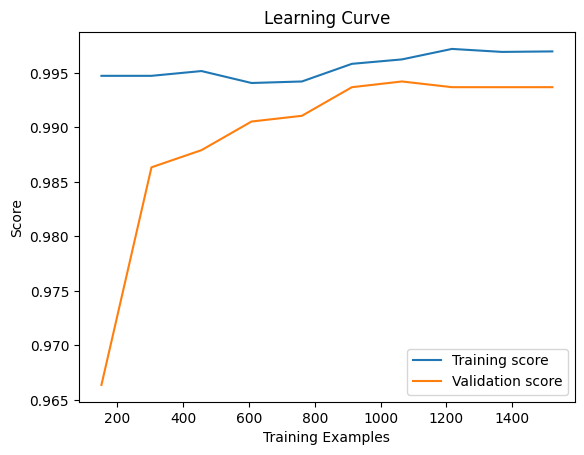

In [50]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.show()


From these overfitting tests, we can say we've done a good job, the model is precise with no signs of overfitting.

In [51]:
import joblib
joblib.dump(clf, '../models/log_classifier.joblib')

['../models/log_classifier.joblib']